<h2><center>NLP -  Logistic Regression & ELMo</center></h2> 

***

### Imports

In [49]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


#### Loading Dataset

Train Data

In [30]:
fake_df = pd.read_csv("C://Users//sophi//OneDrive//DHBW//5. Semester//NLP//nlp//data//Fake.csv")
true_df = pd.read_csv("C://Users//sophi//OneDrive//DHBW//5. Semester//NLP//nlp//data//True.csv")


def assign_label(df, label):
    df['label'] = label
    return df

def merge_text(df):
    df['text'] = df['title'] + ' ' + df['text']
    return df

def preprocess_kaggle_df(df, label):
    df = merge_text(df)
    df = assign_label(df, label)
    df = df.drop(['title', 'subject', 'date'], axis=1)
    return df

fake_df = preprocess_kaggle_df(fake_df, 'FAKE')
true_df = preprocess_kaggle_df(true_df, 'REAL')

df_train = pd.concat([fake_df, true_df])

In [31]:
df_train.head()

,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,FAKE


In [32]:
df_train['label'].value_counts()

label
FAKE    23481
REAL    21417
Name: count, dtype: int64

Test Data

In [2]:
df_raw = pd.read_csv("hf://datasets/newsmediabias/fake_news_elections_labelled_data/cleaned_fakenewsdata.csv")

c:\Users\sophi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_raw.head(5)

,text,label
0,""""""" Study in journal , Nature Communications :...",REAL
1,""""""" Zelensky told the council that he was ther...",REAL
2,""""""" Central bankers and bureaucrats are seizin...",REAL
3,""""""" Last updated on .From the section Swimming...",REAL
4,THE discussion in the Morning Star and elsewhe...,REAL


#### Pre-processing pipeline

In [4]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
class NLTKTokenizer():
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def transform(self, X):
        # Tokenization
        return X.apply(self.tokenize)

    def tokenize(self, text):
        # Normalization
        text = re.sub(r'\W', ' ', str(text))  # only alphanumeric characters
        
        tokens = word_tokenize(text.lower())  
        
        # Stopwords 
        filtered_tokens = [t for t in tokens if t not in self.stop_words and t not in string.punctuation]

        # Lemmatization (+ POS-Tagging)
        lemmatized_tokens = [self.lemmatize_with_pos(token, pos) for token, pos in pos_tag(filtered_tokens)]
        
        return ' '.join(lemmatized_tokens)

    def lemmatize_with_pos(self, token, pos):
        # convert NLTK-POS-Tags in WordNet-POS-Tags
        pos = self.get_wordnet_pos(pos)
        return self.lemmatizer.lemmatize(token, pos=pos) if pos else self.lemmatizer.lemmatize(token)

    def get_wordnet_pos(self, nltk_pos):
        # convert NLTK-POS-Tags in WordNet-POS-Tags
        if nltk_pos.startswith('J'):
            return 'a'  # adjectives
        elif nltk_pos.startswith('V'):
            return 'v'  # verbs
        elif nltk_pos.startswith('N'):
            return 'n'  # nouns
        elif nltk_pos.startswith('R'):
            return 'r'  # adverbs
        else:
            return None 


In [33]:
# train data
FakeNewsTrain = NLTKTokenizer()
df_fakenews_train = FakeNewsTrain.transform(df_train['text'])

df_fakenews_train.head()

0    donald trump sends embarrass new year eve mess...
1    drunk brag trump staffer start russian collusi...
2    sheriff david clarke become internet joke thre...
3    trump obsess even obama name cod website image...
4    pope francis call donald trump christmas speec...
Name: text, dtype: object

In [35]:
# test data
FakeNews = NLTKTokenizer()
df_fakenews = FakeNews.transform(df_raw['text'])

df_fakenews.head()

0    study journal nature communication chain event...
1    zelensky tell council behalf die bucha civilia...
2    central banker bureaucrat seize recent turmoil...
3    last updated section swim fina swim world gove...
4    discussion morning star elsewhere leave approa...
Name: text, dtype: object

Bag-of-words

In [7]:
# # Initialize CountVectorizer for Bag-of-Words
# vectorizer = CountVectorizer()

# # Fit and transform the data
# X_bow = vectorizer.fit_transform(df_fakenews)

# # Vocabulary and feature matrix
# print("Vocabulary:", vectorizer.vocabulary_)
# print("Bag-of-Words Matrix:\n", X_bow.toarray())


tf-idf

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
#tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the data
#X_tfidf = tfidf_vectorizer.fit_transform(df_fakenews)

# Vocabulary and TF-IDF matrix
#print("Vocabulary:", tfidf_vectorizer.vocabulary_)
#print("TF-IDF Matrix:\n", X_tfidf.toarray())


Labels to binary

In [36]:
df_train_labels = df_train
df_train_labels['label_numeric'] = df_train_labels['label'].map({'REAL': 1, 'FAKE': 0})

df_train_label_list = df_train_labels['label_numeric']

df_train_label_list.to_list()
df_train_label_list

0        0
1        0
2        0
3        0
4        0
        ..
21412    1
21413    1
21414    1
21415    1
21416    1
Name: label_numeric, Length: 44898, dtype: int64

In [37]:
df_labels = df_raw
df_labels['label_numeric'] = df_labels['label'].map({'REAL': 1, 'FAKE': 0})

df_label_list = df_labels['label_numeric']

df_label_list.to_list()
df_label_list

0       1
1       1
2       1
3       1
4       1
       ..
9508    1
9509    1
9510    1
9511    1
9512    1
Name: label_numeric, Length: 9513, dtype: int64

Split into train / test

In [10]:
# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(df_fakenews, df_label_list, test_size=0.2, random_state=42)

Balancing dataset

In [11]:
# df_training_set = pd.DataFrame({'text' : X_train, 'label' : y_train})


In [12]:
# df_training_set.shape

(7610, 2)

In [13]:
# majority = df_training_set[df_training_set['label'] == 1]
# minority = df_training_set[df_training_set['label'] == 0]

# print(f"Minorities: {minority.shape} \nMajority: {majority.shape}")


# # upsampling

# data_minority_upsampled = resample(minority, 
#                                    replace=True,  
#                                    n_samples=len(majority),  
#                                    random_state=42) 

# print(f"Minority: {data_minority_upsampled.shape}, Majority: {majority.shape}")
# data = pd.concat([majority, data_minority_upsampled])
# data = data.sample(frac=1, random_state=42).reset_index(drop=True)


# downsample Dataset

# data_majority_downsampled = resample(majority, 
#                                    replace=True,  
#                                    n_samples=len(minority),  
#                                    random_state=42)

# print(f"Minority: {minority.shape}, Majority: {data_majority_downsampled.shape}")
# data = pd.concat([minority, data_majority_downsampled])
# data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# data['label'].value_counts()

Minorities: (2186, 2) 
Majority: (5424, 2)
Minority: (2186, 2), Majority: (2186, 2)


label
0    2186
1    2186
Name: count, dtype: int64

### Logistic Regression

In [14]:
# X_train = data['text']
# y_train = data['label']

# X_train.shape, y_train.shape

((4372,), (4372,))

In [38]:
X_train = df_fakenews_train  # Preprocessed Text aus df_train
y_train = df_train_label_list  # Labels aus df_train

X_test = df_fakenews  # Preprocessed Text aus df_raw
y_test = df_label_list

In [39]:
# Convert the text to a bag-of-words representation
vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()
#X_train_vec = vectorizer.fit_transform(X_train)
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
#X_test_vec = vectorizer.transform(X_test)
X_test_vec = tfidf_vectorizer.transform(X_test)

In [40]:
print(y_train.shape, X_train_vec.shape)

(44898,) (44898, 113760)


In [16]:
#print(y_train.shape, X_train_vec.shape)

(4372,) (4372, 37969)


Confusion Matrix:
[[1973  750]
 [4492 2298]]
Accuracy: 44.90%
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.72      0.43      2723
           1       0.75      0.34      0.47      6790

    accuracy                           0.45      9513
   macro avg       0.53      0.53      0.45      9513
weighted avg       0.63      0.45      0.46      9513



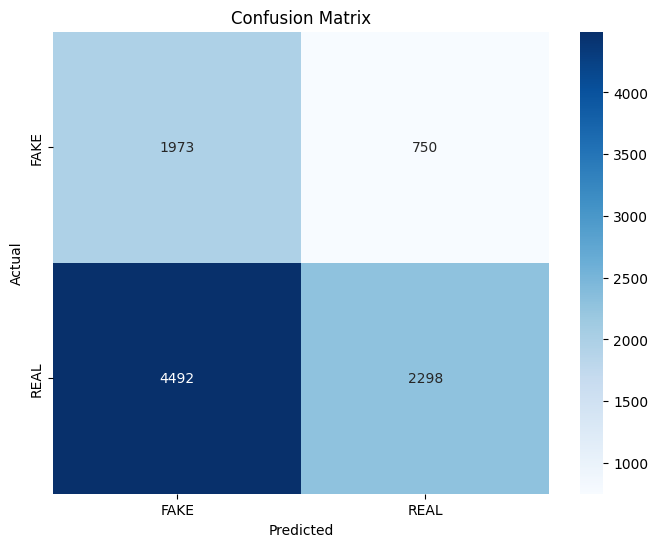

In [41]:
# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_vec)

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

[[397 140]
 [397 969]]
Accuracy: 71.78%
Classification:               precision    recall  f1-score   support

           0       0.50      0.74      0.60       537
           1       0.87      0.71      0.78      1366

    accuracy                           0.72      1903
   macro avg       0.69      0.72      0.69      1903
weighted avg       0.77      0.72      0.73      1903



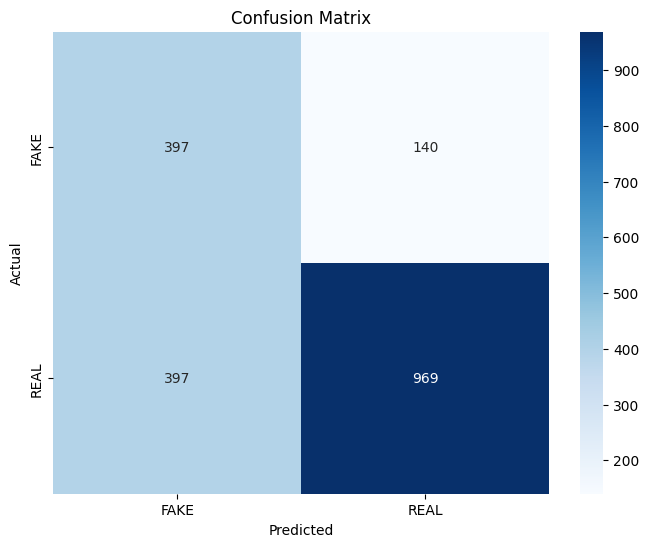

In [ ]:

# # Train a logistic regression classifier
# classifier = LogisticRegression()
# classifier.fit(X_train_vec, y_train)

# # Make predictions on the test set
# y_pred = classifier.predict(X_test_vec)

# conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# classification = classification_report(y_test, y_pred)
# print(f'Classification: {classification}')


# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

In [42]:
print(classification)

              precision    recall  f1-score   support

           0       0.31      0.72      0.43      2723
           1       0.75      0.34      0.47      6790

    accuracy                           0.45      9513
   macro avg       0.53      0.53      0.45      9513
weighted avg       0.63      0.45      0.46      9513



In [18]:
# print(classification)

              precision    recall  f1-score   support

           0       0.50      0.74      0.60       537
           1       0.87      0.71      0.78      1366

    accuracy                           0.72      1903
   macro avg       0.69      0.72      0.69      1903
weighted avg       0.77      0.72      0.73      1903



In [19]:
# class TextPreprocessor:
#     def __init__(self):
#         self.stop_words = set(stopwords.words('english'))
#         self.lemmatizer = WordNetLemmatizer()


#     def preprocess(self, text):
#         text = re.sub(r'\W', ' ', text)  # Remove non-word characters
#         text = text.lower()  # Convert to lowercase
#         tokens = word_tokenize(text)  # Tokenize text
#         tokens = [t for t in tokens if t not in self.stop_words and t not in string.punctuation]  # Remove stopwords
#         tokens = [self.lemmatizer.lemmatize(t) for t in tokens]  # Lemmatization
#         pos_tags = nltk.pos_tag(tokens)  # POS Tagging
#         return ' '.join([f"{word}/{tag}" for word, tag in pos_tags])

# preprocessor = TextPreprocessor()
# df_training_set1 = df_training_set.copy()
# df_training_set1['processed_news'] = df_training_set1['text'].apply(preprocessor.preprocess)

# # 3. Encode Labels
# # Convert labels (REAL/FAKE) to numeric (1/0)
# df_training_set1['label_numeric'] = df_training_set1['label'].map({'REAL': 1.0, 'FAKE': 0.0})

# # 4. Split Dataset (Two-thirds training, one-third testing)
# X = df_training_set1['processed_news']
# y = df_training_set1['label_numeric']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# # 5. Bag-of-Words Representation
# vectorizer = CountVectorizer()
# X_train_bow = vectorizer.fit_transform(X_train)
# X_test_bow = vectorizer.transform(X_test)

# # 6. Train Logistic Regression Model
# model = LogisticRegression()
# model.fit(X_train_bow, y_train)

# # 7. Predictions
# y_pred = model.predict(X_test_bow)

# # 8. Evaluation
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# print("Confusion Matrix:")
# conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")


# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

In [43]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

In [21]:
# pip install -U spacy
# python -m spacy download en_core_web_sm
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Process whole documents
text = ("When Sebastian Thrun started working on self-driving cars at "
        "Google in 2007, few people outside of the company took him "
        "seriously. “I can tell you very senior CEOs of major American "
        "car companies would shake my hand and turn away because I wasn’t "
        "worth talking to,” said Thrun, in an interview with Recode earlier "
        "this week.")
doc = nlp(text)

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)
print(doc.vector)

Noun phrases: ['Sebastian Thrun', 'self-driving cars', 'Google', 'few people', 'the company', 'him', 'I', 'you', 'very senior CEOs', 'major American car companies', 'my hand', 'I', 'Thrun', 'an interview', 'Recode']
Verbs: ['start', 'work', 'drive', 'take', 'tell', 'shake', 'turn', 'talk', 'say']
Sebastian Thrun PERSON
Google ORG
2007 DATE
American NORP
Thrun GPE
Recode ORG
earlier this week DATE
[ 0.07883938 -0.19918318 -0.03542703 -0.00225801  0.01609143  0.02420185
  0.2685016  -0.14018258  0.04192545  0.09063438 -0.15656708 -0.03824966
 -0.18427953  0.06500901  0.00180464  0.14695618 -0.05646211  0.17553093
  0.06640247  0.09014252 -0.06026545  0.27166754 -0.063914   -0.14185911
  0.09478685 -0.18107353  0.02416617  0.08465307  0.12047047  0.2452551
 -0.11021873  0.08413851  0.08253026  0.07811399 -0.12140073 -0.33895823
 -0.01267937 -0.05372773  0.14931943 -0.22917105 -0.10888431  0.20141827
 -0.01555647 -0.10065593  0.22837694 -0.09191441  0.07120742  0.24610817
  0.36448592  0.0

In [44]:
tem_train = pd.DataFrame(X_train)

In [45]:
tem_test = pd.DataFrame(X_test)

In [46]:
# Funktion zur Vektorisierung
def vectorize_text(text):
    doc = nlp(text)
    return doc.vector

# Anwenden auf die Spalte
X_train_w2v = tem_train['text'].apply(vectorize_text)

X_test_w2v = tem_test['text'].apply(vectorize_text)

In [47]:
docs_train = [nlp(doc).vector for doc in tem_train.text]
X_train = np.vstack(docs_train)
print('Shape of train set: {}'.format(X_train.shape))

Shape of train set: (44898, 96)


In [ ]:
# docs_train = [nlp(doc).vector for doc in tem_train.text]
# X_train = np.vstack(docs_train)
# print('Shape of train set: {}'.format(X_train.shape))

Shape of train set: (4372, 96)


In [48]:
docs_train = [nlp(doc).vector for doc in tem_test.text]
X_test = np.vstack(docs_train)
# print('Shape of train set: {}'.format(X_test.shape))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 96 and the array at index 5549 has size 0

In [ ]:
# docs_train = [nlp(doc).vector for doc in tem_test.text]
# X_test = np.vstack(docs_train)
# print('Shape of train set: {}'.format(X_test.shape))

Shape of train set: (1903, 96)


In [ ]:
# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

classification = classification_report(y_test, y_pred)
print(f'Classification: {classification}')


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

[[312 225]
 [486 880]]
Accuracy: 62.64%
Classification:               precision    recall  f1-score   support

           0       0.39      0.58      0.47       537
           1       0.80      0.64      0.71      1366

    accuracy                           0.63      1903
   macro avg       0.59      0.61      0.59      1903
weighted avg       0.68      0.63      0.64      1903



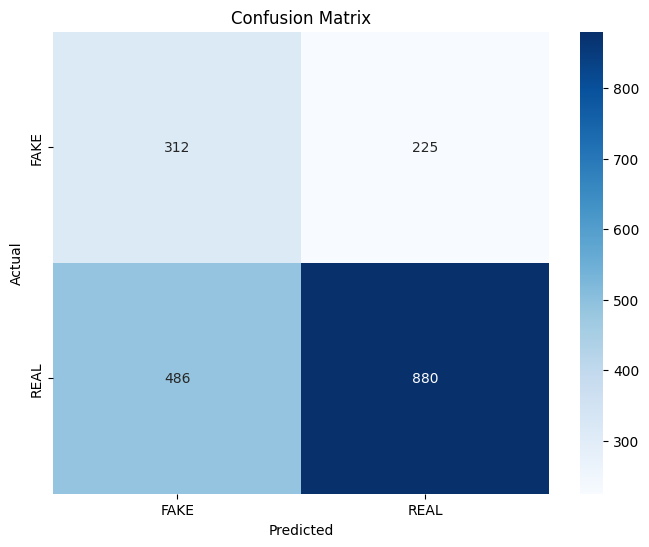

In [ ]:
# # Train a logistic regression classifier
# classifier = LogisticRegression()
# classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = classifier.predict(X_test)

# conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# classification = classification_report(y_test, y_pred)
# print(f'Classification: {classification}')


# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

***

### ELMo (Embeddings from Language Models)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_fakenews, df_label_list, test_size=0.2, random_state=42)

# Balancing der Trainingsdaten
df_training_set = pd.DataFrame({'text': X_train, 'label': y_train})
majority = df_training_set[df_training_set['label'] == 1]
minority = df_training_set[df_training_set['label'] == 0]

data_majority_downsampled = resample(majority, replace=True, n_samples=len(minority), random_state=42)
data = pd.concat([minority, data_majority_downsampled])
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

X_train = data['text']
y_train = data['label']


# Laden von ELMo aus TensorFlow Hub
elmo = hub.load("https://tfhub.dev/google/elmo/2")


def elmo_embedding(texts):
    return elmo.signatures["default"](tf.constant(texts))["elmo"]

# ELMo-Embedding für Training und Test
X_train_embeddings = np.array([elmo_embedding([text]).numpy().mean(axis=1) for text in X_train])
X_test_embeddings = np.array([elmo_embedding([text]).numpy().mean(axis=1) for text in X_test])

# Deep Learning Modell (z. B. ein neuronales Netz)
def build_dl_model(input_dim):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Trainingsdaten für das DL-Modell
input_dim = X_train_embeddings.shape[1]
dl_model = build_dl_model(input_dim)

# Trainiere das Modell
dl_model.fit(X_train_embeddings, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Vorhersagen auf Testdaten
y_pred_dl = dl_model.predict(X_test_embeddings).flatten()
y_pred_dl = np.where(y_pred_dl > 0.5, 1, 0)

# Stacking (Optional)
stacking_model = StackingClassifier(estimators=[
    ('logreg', LogisticRegression()),
    ('rf', RandomForestClassifier())
], final_estimator=LogisticRegression(), n_jobs=-1)

stacking_model.fit(X_train_embeddings, y_train)
y_pred_stacking = stacking_model.predict(X_test_embeddings)

# Evaluierung
conf_matrix_dl = confusion_matrix(y_test, y_pred_dl)
accuracy_dl = accuracy_score(y_test, y_pred_dl)
classification_dl = classification_report(y_test, y_pred_dl)

print("Deep Learning Model:")
print(f"Confusion Matrix:\n{conf_matrix_dl}")
print(f"Accuracy: {accuracy_dl * 100:.2f}%")
print(f"Classification Report:\n{classification_dl}")

conf_matrix_stack = confusion_matrix(y_test, y_pred_stacking)
accuracy_stack = accuracy_score(y_test, y_pred_stacking)
classification_stack = classification_report(y_test, y_pred_stacking)

print("\nStacking Model:")
print(f"Confusion Matrix:\n{conf_matrix_stack}")
print(f"Accuracy: {accuracy_stack * 100:.2f}%")
print(f"Classification Report:\n{classification_stack}")

KeyboardInterrupt: 